*Page and Latex Commands*
$\newcommand{\C}{\mathbb{C}}
\renewcommand{\R}{\mathbb{R}}
\renewcommand{\Z}{\mathbb{Z}}
\renewcommand{\N}{\mathbb{N}}
\newcommand{\Q}{\mathbb{Q}}
\newcommand{\mP}{\mathcal{P}}
\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}
$

In [1]:
from jupyterthemes import jtplot
jtplot.style()

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sys

# Self Defined Functions
sys.path.append('..\lib')

from design import *
from findiff import *
from opt import *
from krot import *

# Kantorovich-Rubenstein OT with Linear Solvers

**Problem Statement**

Provided initial mass distribution $\rho$ and final mass distribution $\sigma$ over a compact metric space $X$, along with the gradient of the cost function for each point in the space $\nabla c : x\in X \rightarrow \R^+$ find the function which minimizes the following integral equation

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & |\nabla \phi(x)|\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$


**Design Method**

* Solve $\nabla u$

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= \sigma - \rho\\
\frac{\partial u}{\partial n} = 0,&\quad \text{ on } \partial \Omega \end{align*}$$

* Solve $\nabla p$
$$\begin{align*}
-\nabla \cdot (A^* \nabla p) &= -2(u-u_0)\\
p = 0,&\quad \text{ on } \partial \Omega \end{align*}$$

* Update $\theta$
$$\begin{align*}
\theta_{k+1} = \max \bigg( 0,\min \bigg(1,\theta_k-t_k\bigg(\ell_k+\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\bigg) \bigg)\bigg)\end{align*}$$

* Update $\phi$
$$\begin{align*}
\phi_{k+1} = \phi_k-t_k\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\end{align*}$$

*Specifics*

$$\begin{align*}
\lambda_- = \bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-1},&\quad \lambda_+ = \alpha\theta+\beta(1-\theta)\\
A^* = \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}&
\begin{pmatrix} \lambda_+ & 0\\ 0 & \lambda_-\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
&=\begin{pmatrix}
\lambda_+\cos^2(\phi)+\lambda_-\sin^2(\phi) & (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi)
\\ (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi) & \lambda_+\sin^2(\phi)+\lambda_-\cos^2(\phi)
\end{pmatrix}\end{align*}$$

Differentation

$$\begin{align*}
\frac{\partial\lambda_-}{\partial\theta} &= -\bigg(\frac{1}{\alpha} - \frac{1}{\beta}\bigg)\bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-2}\\
\frac{\partial\lambda_+}{\partial\theta} &= \alpha-\beta\\
\frac{\partial A}{\partial\theta} &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \frac{\partial\lambda_+}{\partial\theta} & 0\\ 0 & \frac{\partial\lambda_-}{\partial\theta}\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
\frac{\partial A}{\partial\phi} &= \begin{pmatrix} (-\lambda_++\lambda_-)(2\cos(\phi)\sin(\phi)) & (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi))
\\ (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi)) & (\lambda_+-\lambda_-)(2\cos(\phi)\sin(\phi)) \end{pmatrix}\end{align*}$$


### Helper Functions

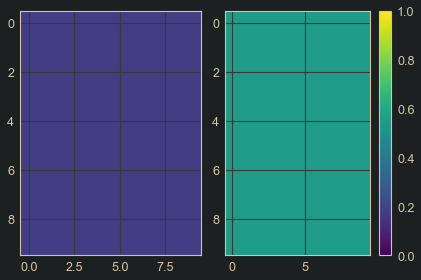

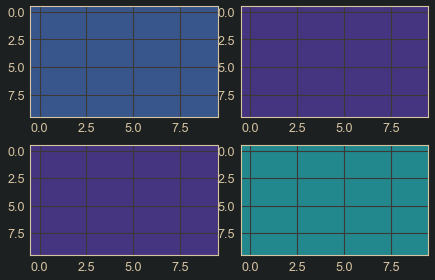

In [7]:
#GRID
n,m = 10,10

#COEFF
alpha = 1
beta = .1
theta = .5*np.ones((n,m))
phi = .5*np.ones((n,m))

#GENERATOR FUNCTIONS
lamM,lamP = genLam(alpha,beta,theta)
A = genA(lamM,lamP,phi)

plt.figure(tight_layout=True)
plt.subplot(121)
plt.imshow(lamM, vmin=0, vmax=1, aspect='auto')
plt.subplot(122)
plt.imshow(lamP, vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.show()

plt.figure(tight_layout=True)
plt.subplot(221)
plt.imshow(A[:,:,0], vmin=0, vmax=1, aspect='auto')
plt.subplot(222)
plt.imshow(A[:,:,1], vmin=0, vmax=1, aspect='auto')
plt.subplot(223)
plt.imshow(A[:,:,2], vmin=0, vmax=1, aspect='auto')
plt.subplot(224)
plt.imshow(A[:,:,3], vmin=0, vmax=1, aspect='auto')
plt.show()


## Two Dimensional Example

(2, 441, 4)


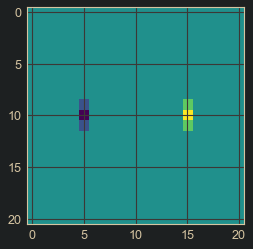

In [28]:
n = m = 21
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,m))

BC = "Neumann"

# Initial Distribution
rho = np.zeros((n,m))
rho[m//2,n//4] = 1
rho[m//2-1,n//4] = .5
rho[m//2+1,n//4] = .5

# Final Distribution
sigma = np.zeros((n,m))
sigma[m // 2,3*n // 4] = 1
sigma[m // 2-1,3*n // 4] = .5
sigma[m // 2+1,3*n // 4] = .5

f = (sigma-rho).flatten()

#Lambda
alpha = 1
beta = .1
theta = .5*np.ones((n,m))
phi = .5*np.ones((n,m))
lamM,lamP = genLam(alpha,beta,theta)


# FDM
Dx = D2xFE(n,m, BC,matrix=True)
Dy = D2yFE(n,m, BC,matrix=True)
Div = np.array([Dx,Dy])
A = genA(lamM,lamP,phi).reshape(n*m,4)

print((Div).shape)
print((A).shape)

# Plotting
plt.imshow(f.reshape((n,m)))

**Solve for $\nabla u$**

In [14]:
phi = cp.Variable((n,m,2))
prob = cp.Problem(cp.Minimize(cp.sum_squares(Div@A@phi+f.flatten())))
prob.solve()

ValueError: Expressions of dimension greater than 2 are not supported.

**Solve for $p$**